<a href="https://colab.research.google.com/github/cserock/colab-examples/blob/main/06_BERT_%EC%98%88%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT를 활용한 영화 리뷰 감정 분석(Sentiment Analysis)

In [1]:
# 파이썬 버전 확인
!python --version

Python 3.12.12


# 0. 필요한 패키지 설치

In [42]:
!pip install wordcloud
!pip install transformers

# 1. 전처리

먼저 이 프로젝트에 사용할 데이터를 불러온다. 데이터는 이전에 언급한 네이버 영화 리뷰 데이터를 사용한다. 훈련을 위한 데이터와 테스트를 위한 데이터를 따로 가져간다. 데이터는 사용자의 id, 유저들의 영화리뷰 내용을 담은 document, 마지막으로 해당 영화에 만족하는지(1) 또는 불만족하는지(0)를 나타내는 타깃 특성인 label로 이루어져있다.

[네이버 영화 리뷰 데이터](https://github.com/e9t/nsmc/)

In [3]:
# 필요한 라이브러리 불러오기
import pandas as pd
import urllib.request

In [4]:
# 영화 리뷰 정보 다운로드하기
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x78c2fb56df70>)

In [5]:
# Pandas로 데이터 불러오기
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [88]:
# 데이터 사이즈 확인
train_data.shape, test_data.shape

((149995, 3), (49997, 3))

In [7]:
# 데이터 확인
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [87]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [85]:
# 결측값이 존재하므로 결측값이 존재하는 행을 제거합니다.
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [86]:
# 결측값이 존재하므로 결측값이 존재하는 행을 제거합니다.
test_data = test_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(test_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [89]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)

/tmp/ipython-input-2657199743.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



##1.1 EDA

데이터를 최대한 분석하는 것이 분석 성공의 열쇠이기 때문에, 가장 먼저 기본적으로 해볼 수 있는 EDA를 모두 해본다.

In [9]:
#1. 데이터의 결측치 확인
train_data.isnull().sum()

,0
id,0
document,5
label,0


In [10]:
test_data.isnull().sum()

,0
id,0
document,3
label,0


데이터의 결측치가 document 부분에서 존재하기는 하지만, 타깃 레이블인 label 칼럼에는 존재하지 않는다. 아무래도 리뷰를 입력하기 귀찮아 만족 여부만 답한 사람도 있을 것이다. 영화에 대해 세부적인 리뷰가 없는 것에 대해서는 아쉽지만, 그럼에도 불구하고 만족도에 대한 정보는 타깃에 있으므로 일단 결측치는 제거하지 않는다.

In [11]:
# 타깃의 클래스 수 확인하기
train_data["label"].value_counts()

,count
label,
0,75173
1,74827


In [12]:
test_data["label"].value_counts()

,count
label,
1,25173
0,24827


[Text(0.5, 1.0, 'Customer Satisfaction(Train)')]

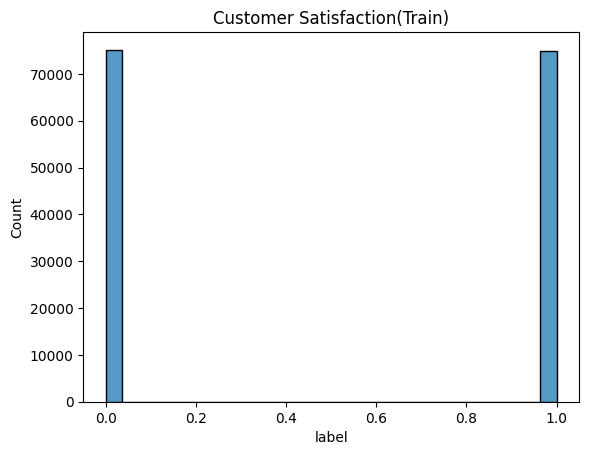

In [91]:
# 클래스 불균형 (class imbalance) 확인하기
import seaborn as sns

sns.histplot(train_data["label"]).set(title="Customer Satisfaction(Train)")

일단 훈련 데이터에서 클래스가 균형 잡힌 것으로 확인된다. 클래스가 매우 불균형하여 따로 두 레이블을 고르게 세팅할 필요가 없는 것이다.

다음으로 리뷰 데이터의 모든 단어를 볼 수 있는 WordCloud를 활용하여 시각화해보자.

In [14]:
# 1. 필요한 모듈 불러오기
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
# %matplotlib inline

In [15]:
# 한글 폰트 준비
urllib.request.urlretrieve("http://macsplex.com/?module=file&act=procFileDownload&file_srl=2851&sid=ea4a36b12467c4446c21e70762c7d10f&module_srl=2822g", filename="AppleGothic.ttf")

('AppleGothic.ttf', <http.client.HTTPMessage at 0x78c2ef710560>)

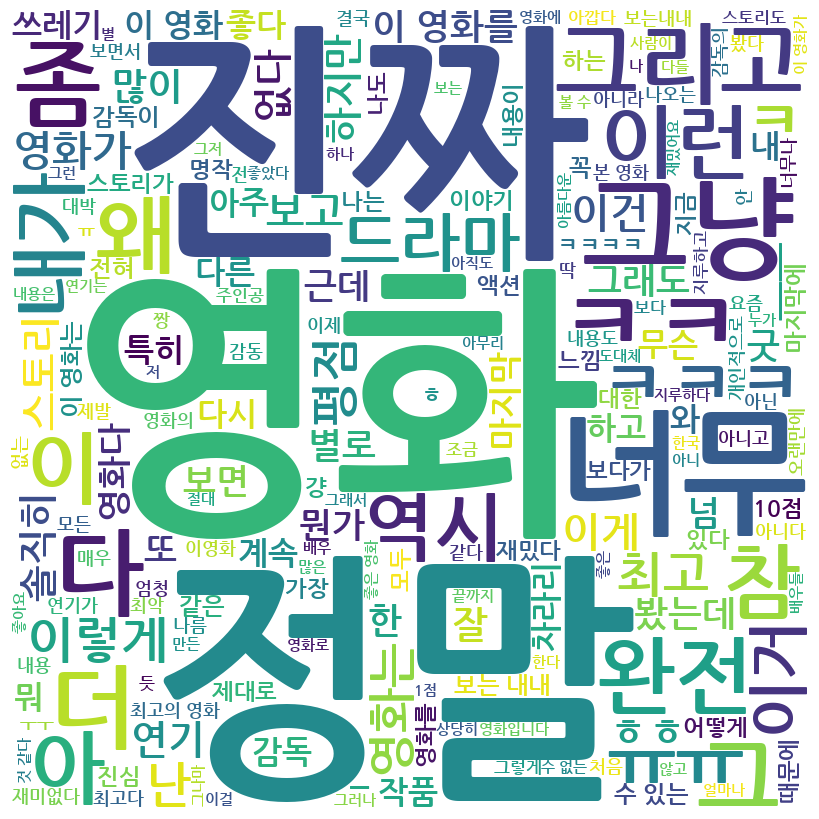

In [16]:
# 2. Stopwords 및 특수문자 필터링을 위한 준비

comment_words = ''
stopwords = set(STOPWORDS)

tokenized_text = []

# 3. 문장 데이터를 단어화하기
for val in train_data["document"]:

  # 문장을 string으로 만들기
  val = str(val)

  # 문장을 쪼개기
  tokens = val.split()

  tokenized_text.append(tokens)
  comment_words += " ".join(tokens) + " "

wordcloud = WordCloud(width = 800, height = 800,
                font_path='AppleGothic.ttf',
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

위 WordCloud를 보니 "정말", "영화", "진짜" 등의 단어가 가장 많이 나온 것을 알수있다. 하지만 엄밀히 따지자면, 이 단어들은 직접적으로 한 사람의 감정을 나타내기 보다는 특정한 대상이나, 그 대상을 확대하여 표현하기 위한 부사들이다. 이 단어들은 직접적으로 감정을 분석하는데 있어 도움이 되지 않기 때문에 이러한 단어들은 Stopwords로써 필터링할 수 있다.

In [17]:
# 필터링할 추가적인 stopwords들 정의

stopwords_2 = ["영화", "진짜", "정말", "이거", "그냥", "너무", "영화가", "영화는",
             "이거", "이게", "이건", "영화의", "어떤", "아주", "계속", "영화다",
             "영화를", "그리고"
]

##1.2 토큰화 및 Stopwords(불용어) 제거

WordCloud를 통해 본 것처럼, 모든 문장을 단어로 토큰화하고, 이전에 새롭게 정의한 불용어를 제거한다.

In [18]:
# 토큰화된 문장확인
tokenized_text[0]

['아', '더빙..', '진짜', '짜증나네요', '목소리']

In [19]:
len(tokenized_text)

150000

In [20]:
# 새로운 불용어와 기존 불용어 필터링하기

def filter_stopwords(tokenized_text, stopwords_2):
  tokenized_filtered = []

  for i in tokenized_text:
    for word in i:
      if word not in stopwords and word not in stopwords_2:
        tokenized_filtered.append(word)

  return tokenized_filtered

In [21]:
tokenized_filtered = filter_stopwords(tokenized_text, stopwords_2)

In [22]:
# 필터링 되었는지 확인
tokenized_filtered[0:10]

['아',
 '더빙..',
 '짜증나네요',
 '목소리',
 '흠...포스터보고',
 '초딩영화줄....오버연기조차',
 '가볍지',
 '않구나',
 '너무재밓었다그래서보는것을추천한다',
 '교도소']

In [23]:
len(tokenized_filtered)

1083270

In [24]:
# 각 단어가 얼마나 나왔는지 카운트해보기

import operator

def word_count(tokenized_data):
  word_counter = {}

  for i in tokenized_data:
    if i in word_counter.keys():
      word_counter[i] += 1
    else:
      word_counter[i] = 1

  # 많이 나온 순서대로 정렬

  sorted_dict = dict( sorted(word_counter.items(),
                           key=operator.itemgetter(1), reverse=True))

  return sorted_dict

In [25]:
tokenized_dict = word_count(tokenized_filtered)

In [26]:
# 가장 상위 20개의 단어 보기
def top_20(tokenized_dict):
  top_20_words = list(tokenized_dict.items())[:20]
  return top_20_words

top_20(tokenized_dict)

[('이', 5059),
 ('영화.', 3598),
 ('왜', 3285),
 ('더', 3260),
 ('이런', 3249),
 ('수', 2945),
 ('잘', 2644),
 ('다', 2615),
 ('보고', 2557),
 ('좀', 2449),
 ('그', 2421),
 ('본', 2298),
 ('최고의', 2219),
 ('ㅋㅋ', 2019),
 ('내가', 2000),
 ('없는', 1957),
 ('이렇게', 1828),
 ('완전', 1780),
 ('평점', 1760),
 ('봤는데', 1746)]

크게 의미가 없는 단어들이 아직도 남아있다. 조금 더 불용어들을 필터링해보자.

In [27]:
stopwords_2.extend(["이", "이렇게", "더", "수", "다", "그", "내가", "이렇게",
               "완전", "봤는데", "영화.", "평점", "평점이", "왜", "이런", "본",
               "보고", "잘"
])

In [28]:
tokenized_filtered = filter_stopwords(tokenized_text, stopwords_2)

len(tokenized_filtered)

1038630

In [29]:
tokenized_dict = word_count(tokenized_filtered)

In [30]:
# 가장 상위 20개의 단어 보기
top_20(tokenized_dict)

[('좀', 2449),
 ('최고의', 2219),
 ('ㅋㅋ', 2019),
 ('없는', 1957),
 ('있는', 1739),
 ('좋은', 1726),
 ('보는', 1600),
 ('내', 1595),
 ('다시', 1583),
 ('참', 1508),
 ('많이', 1478),
 ('역시', 1466),
 ('난', 1405),
 ('연기', 1365),
 ('재밌게', 1343),
 ('한', 1323),
 ('쓰레기', 1295),
 ('것', 1277),
 ('하는', 1236),
 ('또', 1231)]

드디어 감정을 나타내는 단어들이 좀 보이기 시작했다. "좀"이라는 말은, 어떻게 보면 직접적인 감정을 드러낸다고 할 수는 없지만, 일반적으로 "좀 그렇다.", "좀 별로다." 라는 식으로 부정적인 뉘앙스로 많이 쓰인다. "좀 좋다.", "좀 괜찮다."라는 말을쓰기도 하지만, 일상에서 자연스럽다고 느낄정도로 긍정적인 어투로 쓰이지는 않는 편이다. 그만큼 이 단어는 어느 정도 부정적인 감정을 나타낼 가능성이 높다. 하지만, "최고의"라는 굉장히 긍정적인 감정을 나타내는 단어가 뒤따른 것으로보아, 자신이 본 컨텐츠를 부정적으로 생각한 사람들 못지 않게, 긍정적으로 본 사람들도 상당히 많다는 것을 보여준다. 뒤 따르는 "ㅋㅋ"라는 웃음의 의성어는, 주로 무언가가 재미있거나 흥미로울 때 많이 쓴다. 이러한 용어의 빈도가 높았다는 사실 역시, 자신이 시청한 콘텐츠를 즐겁게 평가한사람이 많았다는 것을 보여준다. 그 이후에 나오는 "좋은", "재밌게"라는 단어들이 뒤따랐고, 상당히 부정적인 감정을 드러내는 "쓰레기"라는 표현도 상당한 빈도로 나온 것을 알 수 있다. 전체적으로 자신이 본 콘텐츠를 긍정적으로 본 사람들 못지않게, 부정적으로 평가한 사람들도 상당히 많았음을 알 수 있다.

여기서 좀 더 전처리를 해본다. 이번에는 직접적으로 감정이 드러나는 단어를 찾기 위해 직접 감정이 드러나는 레벨까지 가본다. 그 후에, 몇가지 단어들을 특정한 감정으로 대체하여 보도록 하겠다.

In [31]:
stopwords_2.extend(["보는", "내", "다시", "난", "연기", "한", "것", "하는", "또",
                    "역시", "좀", "참", "많이", "없는", "있는"
])

In [32]:
tokenized_filtered = filter_stopwords(tokenized_text, stopwords_2)

len(tokenized_filtered)

1015418

In [33]:
tokenized_dict = word_count(tokenized_filtered)

In [34]:
top_20(tokenized_dict)

[('최고의', 2219),
 ('ㅋㅋ', 2019),
 ('좋은', 1726),
 ('재밌게', 1343),
 ('쓰레기', 1295),
 ('아', 1204),
 ('드라마', 1186),
 ('꼭', 1181),
 ('가장', 1178),
 ('보면', 1176),
 ('ㅋㅋㅋ', 1108),
 ('마지막', 1070),
 ('스토리', 1020),
 ('무슨', 999),
 ('ㅋ', 989),
 ('없고', 981),
 ('.', 981),
 ('볼', 959),
 ('ㅠㅠ', 958),
 ('같은', 956)]

## 1.3 키워드 분석하기

In [35]:
# 감정이 드러난 단어들을 묶어보기

emotion_dict = {"최고의": "극찬", "ㅋㅋ": "웃음", "좋은": "기쁨", "재밌게": "흥미",
                "쓰레기": "혐오", "ㅋㅋㅋ": "웃음", "ㅋ": "무심", "ㅠㅠ": "슬픔"
}

In [36]:
from collections import defaultdict, OrderedDict

emotions_dict = defaultdict(int)

emotions_list = []

for k, v in tokenized_dict.items():
  for key, value in emotion_dict.items():
    if k == key:
      emotions_list.append((value, v))

for k, v in emotions_list:
  if k in emotions_dict:
    emotions_dict[k] += v
  else:
    emotions_dict[k] = v

emotions_dict = OrderedDict(sorted(emotions_dict.items(),
                            key=lambda item: item[1],
                            reverse=True))

emotions_dict

OrderedDict([('웃음', 3127),
             ('극찬', 2219),
             ('기쁨', 1726),
             ('흥미', 1343),
             ('혐오', 1295),
             ('무심', 989),
             ('슬픔', 958)])

In [37]:
# Plotly로 시각화

# Pie Chart
import plotly.express as px

emotions = pd.Series(emotions_dict)

fig = px.pie(emotions, values=emotions, names=emotions.index, title="가장 두드러지게 나타난 감정", hover_data=[emotions], labels=emotions.index)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [38]:
# Bar chart
fig = px.bar(emotions, x=emotions.index, y=emotions, title="가장 두드러지게 나타난 감정")
fig.show()

# 2. 모델링

## 2.1 모델링을 위한 준비

이제는 "대체로 왓챠의 고객들은 콘텐츠에 만족한다."라는 가설을 시험하기 위해 모델링을 준비해야한다. BERT모델에 맞게 인코딩 및 표준화 작업이 필요하다. 이 모델은 Transformer 모델을 기반으로 한다.

다음으로 이 모델을 사용하기 위해 PyTorch가 필요하다. 또한, Transformer 모듈에서 Bert를 사용하기 위한 메소드들을 불러와야한다.

In [44]:
# Bert 사용에 필요한 모듈 불러오기
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, Adafactor, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime

Bert를 위해 조금 더 파워풀한 GPU를 사용해야한다. GPU가 사용되는지 확인한다.

In [45]:
import os

n_devices = torch.cuda.device_count()
print(n_devices)

for i in range(n_devices):
    print(torch.cuda.get_device_name(i))

1
Tesla T4


BERT는 문장의 앞에 [CLS]를 붙이고, 끝에는 [SEP]을 붙여 처리를 해 주어야한다. 그러므로 반복문 등을 활용하여 처리해 주어야한다.

In [46]:
# BERT에 맞는 Tag 달아주기
bert_text = []

for i in train_data['document']:
  bert = ["[CLS] " + str(i) + " [SEP]"]
  bert_text.append(bert)

bert_text[:5]

[['[CLS] 아 더빙.. 진짜 짜증나네요 목소리 [SEP]'],
 ['[CLS] 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나 [SEP]'],
 ['[CLS] 너무재밓었다그래서보는것을추천한다 [SEP]'],
 ['[CLS] 교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정 [SEP]'],
 ['[CLS] 사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다 [SEP]']]

In [47]:
test_text = []

for i in test_data['document']:
  bert = ["[CLS] " + str(i) + " [SEP]"]
  test_text.append(bert)

test_text[:5]

[['[CLS] 굳 ㅋ [SEP]'],
 ['[CLS] GDNTOPCLASSINTHECLUB [SEP]'],
 ['[CLS] 뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아 [SEP]'],
 ['[CLS] 지루하지는 않은데 완전 막장임... 돈주고 보기에는.... [SEP]'],
 ['[CLS] 3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠?? [SEP]']]

이전 단계에서 이미 토큰화된 것을 사용하면 좋겠지만, 위와 같이 CLS 및 SEP 태그를 달아주어야 했기 때문에, 최초의 데이터를 활용했다. 이번에는 Bert multilingual 모델에 있는 tokenizer를 활용하여 토큰화한다.

In [48]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_data = []
for i in bert_text:
  for j in i:
    tokens = tokenizer.tokenize(j)
    tokenized_data.append(tokens)

print(tokenized_data[0:10])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

[['[CLS]', '아', '더', '##빙', '.', '.', '진', '##짜', '짜', '##증', '##나', '##네', '##요', '목', '##소', '##리', '[SEP]'], ['[CLS]', '[UNK]', '.', '.', '.', '포', '##스터', '##보', '##고', '초', '##딩', '##영', '##화', '##줄', '.', '.', '.', '.', '오', '##버', '##연', '##기', '##조', '##차', '가', '##볍', '##지', '않', '##구', '##나', '[SEP]'], ['[CLS]', '[UNK]', '[SEP]'], ['[CLS]', '교', '##도', '##소', '이야기', '##구', '##먼', '.', '.', '솔', '##직', '##히', '재', '##미', '##는', '없다', '.', '.', '평', '##점', '조', '##정', '[SEP]'], ['[CLS]', '사', '##이', '##몬', '##페', '##그', '##의', '익', '##살', '##스', '##런', '연', '##기가', '돋', '##보', '##였던', '영화', '!', '스', '##파', '##이', '##더', '##맨', '##에서', '늙', '##어', '##보', '##이', '##기', '##만', '했', '##던', '커', '##스', '##틴', '던', '##스트', '##가', '너', '##무', '##나', '##도', '이', '##뻐', '##보', '##였다', '[SEP]'], ['[CLS]', '막', '걸', '##음', '##마', '[UNK]', '3', '##세', '##부터', '초', '##등학교', '1', '##학', '##년', '##생', '##인', '8', '##살', '##용', '##영', '##화', '.', '[UNK]', '.', '.', '.', '별', '##반', '##개', '##

In [49]:
tokenized_test_data = []
for i in test_text:
  for j in i:
    tokens = tokenizer.tokenize(j)
    tokenized_test_data.append(tokens)

print(tokenized_test_data[0:5])

[['[CLS]', '굳', '[UNK]', '[SEP]'], ['[CLS]', 'G', '##D', '##NT', '##OP', '##CL', '##AS', '##SI', '##NT', '##H', '##EC', '##L', '##UB', '[SEP]'], ['[CLS]', '뭐', '##야', '이', '평', '##점', '##들은', '.', '.', '.', '.', '나', '##쁘', '##진', '않', '##지만', '10', '##점', '짜', '##리는', '더', '##더', '##욱', '[UNK]', '[SEP]'], ['[CLS]', '지', '##루', '##하지', '##는', '않은', '##데', '완', '##전', '막', '##장', '##임', '.', '.', '.', '돈', '##주', '##고', '보', '##기에', '##는', '.', '.', '.', '.', '[SEP]'], ['[CLS]', '3D', '##만', '아', '##니', '##었', '##어', '##도', '별', '다', '##섯', '개', '줬', '##을', '##텐', '##데', '.', '.', '왜', '3D', '##로', '나', '##와', '##서', '제', '심', '##기를', '불', '##편', '##하게', '하', '##죠', '?', '?', '[SEP]']]


이전 딥러닝 수업에서 padding이 매우 중요하다고 배웠다. 가장자리에 있는 데이터들이 1번만 사용되는 것을 막기 위해 기존 데이터에 0의 테두리를 두르는 것이다. 이 작업이 BERT 모델을 돌리기 위해서도 필요하다.

In [50]:
# padding
input_ids = []
for i in tokenized_data:
  ids = tokenizer.convert_tokens_to_ids(i)
  input_ids.append(ids)

print(input_ids[0])

[101, 9519, 9074, 119005, 119, 119, 9708, 119235, 9715, 119230, 16439, 77884, 48549, 9284, 22333, 12692, 102]


In [51]:
input_ids_test = []
for i in tokenized_test_data:
  ids = tokenizer.convert_tokens_to_ids(i)
  input_ids_test.append(ids)

print(input_ids_test[0])

[101, 8911, 100, 102]


In [52]:
max_len = 128
input_ids = pad_sequences(input_ids, maxlen=max_len, dtype='long', truncating='post', padding='post')
input_ids[0]

array([   101,   9519,   9074, 119005,    119,    119,   9708, 119235,
         9715, 119230,  16439,  77884,  48549,   9284,  22333,  12692,
          102,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [53]:
input_ids_test = pad_sequences(input_ids_test, maxlen=max_len, dtype='long', truncating='post', padding='post')
input_ids_test[0]

array([ 101, 8911,  100,  102,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])

다음으로 Masking을 준비한다.

In [54]:
attention_masks = []

for ids in input_ids:
  ids_mask = []
  for id in ids:
      masked = float(id>0)
      ids_mask.append(masked)
  attention_masks.append(ids_mask)

print(attention_masks[0])
print(len(attention_masks[0]))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
128


In [55]:
attention_masks_test = []

for ids in input_ids_test:
  ids_mask = []
  for id in ids:
      masked = float(id>0)
      ids_mask.append(masked)
  attention_masks_test.append(ids_mask)

print(attention_masks_test[0])
print(len(attention_masks_test[0]))

[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
128


모델링을 위해서는 train 데이터와 validation 데이터를 분리해야한다. 테스트 데이터는 이미 분리되어있다. 다만 이후 모델의 fine-tuning을 위한 데이터와, 이후 모델링을 위해 tensor로 변환할 데이터를 분리해 주어야한다.

In [56]:
X_train, X_val, y_train, y_val = train_test_split(
    input_ids, train_data['label'].values, random_state=42, test_size=0.2)

train_masks, validation_masks, _, _ = train_test_split(attention_masks,
                                                       input_ids,
                                                       random_state=42,
                                                       test_size=0.2)

In [57]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((120000, 128), (30000, 128), (120000,), (30000,))

In [58]:
# Fine-tuning과 Tensor로 사용할 데이터를 분리
X_train_tune = X_train
y_train_tune = y_train
X_val_tune = X_val
y_val_tune = y_val

In [59]:
X_test_tensor = input_ids_test
y_test_tensor = test_data["label"].values
test_masks = attention_masks_test

다음으로 input_ids, 타깃 라벨, masking을 PyTorch로 변환해야한다.

In [60]:
# PyTorch로 변환

X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
train_masks = torch.tensor(train_masks)
X_val_tensor = torch.tensor(X_val)
y_val_tensor = torch.tensor(y_val)
validation_masks = torch.tensor(validation_masks)

In [61]:
X_test_tensor = torch.tensor(X_test_tensor)
y_test_tensor = torch.tensor(y_test_tensor)
test_masks = torch.tensor(attention_masks_test)

이번에는 배치 사이즈를 지정한다. 주로 큰 사이즈를 설정해보고, VRAM 에러 메시지가 난다면, 더 작은 사이즈로 줄여나간다. 8의 배수로 설정하는 것이 일반적이다. 한 블로그를 참조[2]해보니, 32일 때 가장 좋은 성능이 나왔다고 한다. 그래서 이를 batch_size의 값으로 설정했다.

In [62]:
batch_size = 32

train = TensorDataset(X_train_tensor, train_masks, y_train_tensor)
train_sampler = RandomSampler(train)

val = TensorDataset(X_val_tensor, validation_masks, y_val_tensor)
val_sampler = SequentialSampler(val)


test = TensorDataset(X_test_tensor, test_masks, y_test_tensor)
test_sampler = RandomSampler(test)

train_dataloader = DataLoader(train, sampler=train_sampler, batch_size=batch_size)
val_dataloader = DataLoader(val, sampler=val_sampler, batch_size=batch_size)
test_dataloader = DataLoader(test, sampler=test_sampler, batch_size=batch_size)

다음으로 GPU가 사용가능한지를 체크해야한다. GPU를 사용할 수 있게 설정해준다. PyTorch는 GPU를 돌릴 수 있는 CUDA 라이브러리를 지원하는데, PyTorch를 통해 CUDA를 사용할 수 있는 디바이스를 초기화한다.

In [83]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


##2.2 모델 Fine-Tuning

BERT모델은 Fine-Tuning을 통해 원하는 목적에 맞게 최적화 시킬 수도 있다. 이번 단계에서는 모델의 최종 학습 전, 모델을 Fine-Tuning하여 성능을 올리고자 한다.

일단 BERT 모델을 초기화한다. Transformers의 BertForSequenceClassification 모듈을 활용한다. 타깃은 0과 1로 이루어져 있기 때문에, 라벨의 수는 2가 될 것이다. 사용할 BERT모듈의 이름은 "bert-case-multilingual-cased"라는 것으로 영어 이외의 언어 텍스트 데이터를 처리하는데 유용하다.

In [64]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

다음으로 필요한 파라미터만 Fine-Tuning을 진행할 수 있도록 requires_grad를 False로 설정한다.

In [65]:
for param in model.base_model.parameters():
    param.requires_grad = False

Fine Tuning을 위해서는 Transformer모듈이 제공하는 Trainer 및 TrainingArguments라는 메소드를 사용해야하는데, 이를 위해서는 이 메소드에 입맞에 맞는 형태로 데이터를 넣어주어야한다. 이전에 활용한 train_test_split를 이용해, 데이터를 두 메소드가 원하는 형태로 다시 분리한다. 주의할 것은, 이 메소드들은 리스트의 형태로만 데이터를 받아들이고, 데이터 자체는 모두 string이어야한다는 것이다. 라벨은 궁극적으로 예측할 타깃이기 때문에 string으로 변환시키지 않는다. 이전에 토큰화 단계에서 나눈 데이터들은 추후 실제 학습에 활용할 것이다.

In [66]:
from sklearn.model_selection import train_test_split
train_queries, val_queries, train_docs, val_docs, train_labels, val_labels = train_test_split(
    train_data["id"].apply(str).tolist(),
    train_data["document"].apply(str).tolist(),
    train_data["label"].tolist(),
    test_size=.2
)

다음으로 나눈데이터를 토큰화해야한다. 이 과정에서 BertTokenizerFast라는 transformers 모듈의 객체를 활용할 수 있다.

In [67]:
from transformers import BertTokenizerFast

model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)

train_encodings = tokenizer(train_queries, train_docs, truncation=True, padding='max_length', max_length=max_len)
val_encodings = tokenizer(val_queries, val_docs, truncation=True, padding='max_length', max_length=max_len)

마지막으로 Fine-Tuning을 실시하기 전, 토큰화한 데이터 셋을 인코딩한다.

In [68]:
import torch

class Cord19Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Cord19Dataset(train_encodings, train_labels)
val_dataset = Cord19Dataset(val_encodings, val_labels)


마지막으로 Fine-Tuning을 실시하여, 모델의 학습을 진행하기전에 최적화 시킨다. TrainingArguments 매소드의 경우, 나중에 원한다면 Fine-Tuned된 모델을 사용할 수 있도록 모델을 지정된 경로에 저장할 수 있는 옵션을 제공한다. Epoch가 너무 크면 학습이 너무 오래걸리므로 3으로 가져간다. Batch Size는 학습데이터와 검증 데이터 모두 dataloader를 설정할 때 처럼 32로 세팅해본다. Warm-up step과 weight decay값은 0으로 지정하고, checkpoint는 1개만 가져간다.

In [71]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    eval_strategy="epoch",     # Evaluation is done at the end of each epoch.
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=0,                # number of warmup steps for learning rate scheduler
    weight_decay=0,               # strength of weight decay
    save_total_limit=1,              # limit the total amount of checkpoints. Deletes the older checkpoints.
)


trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.689300,0.688676


TrainOutput(global_step=3750, training_loss=0.6907680826822916, metrics={'train_runtime': 1691.0122, 'train_samples_per_second': 70.963, 'train_steps_per_second': 2.218, 'total_flos': 7893331660800000.0, 'train_loss': 0.6907680826822916, 'epoch': 1.0})

##2.3 모델 학습

모델의 학습을 위해 가장먼저 Optimizer를 지정하고 epochs값을 지정해주어야한다. 여기서는 AdamW와 Adafactor 옵티마이저를 사용하며, 학습률(learning rate)은 1e-5로, 업데이트되며 0으로 나뉘어지는 것을 방지하기 위한 epsilon값은 1e-8로 설정한다. epoch은 3으로 설정했다. Weight Decay값은 이전 tuning 때와 같이 0, num_warmup_steps역시 0으로 설정

In [72]:
# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 1e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값,
                )
# 에폭수
epochs = 1

# 총 훈련 스텝
total_steps = len(train_dataloader) * epochs

# Learning rate decay를 위한 스케줄러
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)


모델링을 위한 마지막 설정은 정확도를 측정할 수 있는 함수를 만들어 주고, 학습에 소요된 시간을 나타내는 함수를 정의해 주는 것이다. 모델의 성능 측정을 위해 둘다 필수적인 요소들이기 때문이다.

In [73]:
# 정확도 계산 함수
def accuracy_measure(y_pred, y):
    pred_flattened = np.argmax(y_pred, axis=1).flatten()
    y_flattened = y.flatten()
    return np.sum(pred_flattened == y_flattened) / len(y_flattened)

# 시간 표시 함수
def time_elapsed(elapsed):
    # 반올림
    elapsed = int(round((elapsed)))
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed))

이제 학습을 할 수 있는 준비를 마쳤다. 학습 전에 Random seed를 고정해야한다. 일반적으로 Random State는 42로 설정하고 시작하기 때문에 여기서도 Seed값은 42로 설정한다. Gradient도 초기화 하여 Optimizer가 Gradient Descent를 진행할 때 도움이 되도록 한다.

In [75]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

본격적으로 학습을 시작한다. 전체적인 단계는 훈련과 검증 두 부분으로 나뉘어진다.

훈련 단계에서는 정해진 에폭수 만큼 학습을 반복한다. 시간을 초기화하고, 비용함수를 게산해야하기 때문에 이 역시 초기화한다. 이전에 설정한 batch_size 만큼, 설정한 데이터로더에서 나누어서 사용한다. 시간이 얼마나 경과 했는지는 이전에 설정한 함수를 활용한다. 배치를 GPU에 입력하면 GPU는 입력된 배치를 처리하기 시작한다. 여기서 Forward Propagation으로 비용함수를 계산하고, Backward Propagation로 Gradient Descent를 수행하며 학습을 하게된다. 이전에 설정한 스케줄러로 learning rate decay를 실시하고, 설정한 batch_size 만큼 데이터를 사용하면, gradient를 다시 초기화하여, 다음 batch_size만큼의 데이터를 사져온다. 이 작업을 반복하면서 모든 데이터를 사용하게 되면, 평균 에러와 평균 학습 시간을 게산한다. Fine-Tuning전 분리한 데이터인 train_dataloader, val_dataloader, test_dataloader를 사용한다.

훈련이 끝나면 검증을 실행하는데, 전반적인 과정은 훈련단게와 비슷하다. 다만, 마지막에 GPU의 예측 결과를 CPU로 가져와, 실제 라벨과 비교하여 정확도를 계산하게된다. 최종 출력 정확도와 소요시간을 계산하며 모든 과정을 마무리한다.

In [76]:
# 본격적인 학습
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================


    # 현재 훈련 조건 표시
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
          elapsed = time_elapsed(time.time() - t0)
          print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)

        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행
        outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)

        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(time_elapsed(time.time() - t0)))
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in val_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)

        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # 그래디언트 계산 안함
        with torch.no_grad():
          # Forward 수행
          outputs = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask)

          # 로스 구함
          logits = outputs[0]

          # CPU로 데이터 이동
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

          # 출력 로짓과 라벨을 비교하여 정확도 계산
          tmp_eval_accuracy = accuracy_measure(logits, label_ids)
          eval_accuracy += tmp_eval_accuracy
          nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(time_elapsed(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 1 ========
Training...
  Batch   500  of  3,750.    Elapsed: 0:01:53.
  Batch 1,000  of  3,750.    Elapsed: 0:03:45.
  Batch 1,500  of  3,750.    Elapsed: 0:05:36.
  Batch 2,000  of  3,750.    Elapsed: 0:07:28.
  Batch 2,500  of  3,750.    Elapsed: 0:09:19.
  Batch 3,000  of  3,750.    Elapsed: 0:11:10.
  Batch 3,500  of  3,750.    Elapsed: 0:13:01.

  Average training loss: 0.68
  Training epcoh took: 0:13:57

Running Validation...
  Accuracy: 0.62
  Validation took: 0:03:27

Training complete!


In [77]:
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = time_elapsed(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)

    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch

    # 그래디언트 계산 안함
    with torch.no_grad():
        # Forward 수행
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = accuracy_measure(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(time_elapsed(time.time() - t0)))

  Batch   100  of  1,563.    Elapsed: 0:00:23.
  Batch   200  of  1,563.    Elapsed: 0:00:46.
  Batch   300  of  1,563.    Elapsed: 0:01:08.
  Batch   400  of  1,563.    Elapsed: 0:01:29.
  Batch   500  of  1,563.    Elapsed: 0:01:51.
  Batch   600  of  1,563.    Elapsed: 0:02:13.
  Batch   700  of  1,563.    Elapsed: 0:02:36.
  Batch   800  of  1,563.    Elapsed: 0:02:57.
  Batch   900  of  1,563.    Elapsed: 0:03:19.
  Batch 1,000  of  1,563.    Elapsed: 0:03:42.
  Batch 1,100  of  1,563.    Elapsed: 0:04:04.
  Batch 1,200  of  1,563.    Elapsed: 0:04:26.
  Batch 1,300  of  1,563.    Elapsed: 0:04:48.
  Batch 1,400  of  1,563.    Elapsed: 0:05:10.
  Batch 1,500  of  1,563.    Elapsed: 0:05:32.

Accuracy: 0.61
Test took: 0:05:46


모델은 약 61%의 정확도로 타깃을 예측

[Text(0.5, 1.0, 'Customer Satisfaction(Test)')]

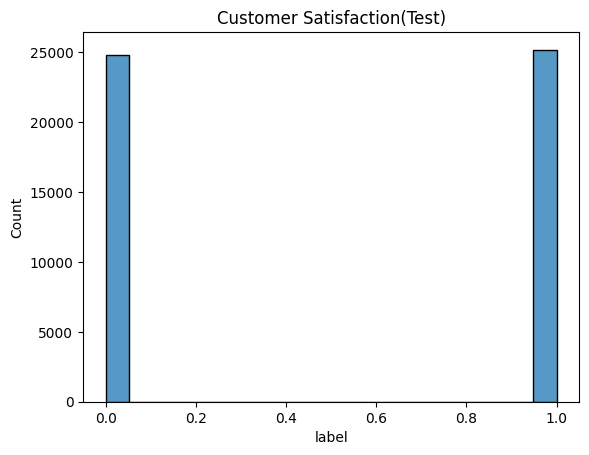

In [78]:
# 실제 테스트 데이터 클래스 균형 보기
sns.histplot(test_data["label"]).set(title="Customer Satisfaction(Test)")